# Dataset Analysis of Protein Structures

## Dataset Overview

In this notebook, we load a curated list of PDB identifiers, download their corresponding structures, and compute the following metrics for each protein:
- **Residue count**: total number of amino acid residues.
- **Chain count**: number of polypeptide chains.
- **Center of mass**: 3D coordinates of the center of mass (X, Y, Z).
- **Average backbone angles**: mean φ (phi) and ψ (psi) angles in degrees.

## Dataset Description

The dataset contains 32 protein structures chosen to capture four broad functional classes:

| Category | Examples | Purpose |
|----------|----------|---------|
| **Enzymes** | 1AKE, 1H2W, 4WNC | Classic catalytic models for RMSD benchmarking |
| **Small single–domain proteins** | 1CRN, 1BRS | Compact folds for φ/ψ angle statistics |
| **Membrane proteins / receptors** | 1A0S, 2RH1, 3MKT | Trans-membrane topology diversity |
| **Large multichain complexes** | 4V4Q, 6VXX | Stress-testing performance on big assemblies |

The table below lists every PDB identifier, its functional family, the total number of residues (computed on the fly), and the source (all structures were downloaded from the RCSB PDB archive).

In [1]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
import requests
from Bio.PDB import PDBList, PDBParser
from Bio.PDB.MMCIFParser import MMCIFParser
import plotly.express as px

pdb_list_file = '../data/pdb_list.txt'

In [3]:
with open(pdb_list_file) as f:
    pdb_ids = [line.strip() for line in f if line.strip()]
    
pdb_ids

['1AKE   # adenylate kinase',
 '2PTC   # trypsinвЂ“inhibitor complex',
 '1LYZ   # hen-egg-white lysozyme',
 '1D66   # dihydrofolate reductase',
 '1H2W   # HIV-1 protease',
 '1H4L   # cytochrome P450-cam',
 '4WNC   # human acetylcholinesterase',
 '2C7E   # alanine racemase',
 '5E8A   # catalytic antibody 48G7',
 '3G5U   # T7 RNA polymerase',
 '1CRN   # crambin (plant protein)',
 '1BRS   # barnase',
 '1PPT   # pancreatic trypsin inhibitor (BPTI)',
 '1TIT   # titin I27 domain',
 '2WXC   # WW domain of Pin1',
 '1A0S   # bacteriorhodopsin',
 '1A0I   # KcsA potassium channel',
 '2POR   # OmpF porin',
 '2RH1   # ОІ2-adrenergic GPCR',
 '3SN6   # Ој-opioid GPCR',
 '3MKT   # leucine transporter (LeuT)',
 '6CP6   # mitochondrial ATP-synthase F1 domain',
 '5I6X   # human GLUT1 glucose transporter',
 '4V4Q   # E. coli 70S ribosome (small subunit)',
 '3J3Q   # yeast mitochondrial ribosome',
 '7KOO   # human 80S ribosome (snapshot)',
 '6VXX   # SARS-CoV-2 spike trimer',
 '5L93   # human clathrin coat

In [4]:
from Bio.PDB.vectors import calc_dihedral
from Bio.PDB import PPBuilder

pdbl = PDBList()
parser = PDBParser(QUIET=True)

STRUCT_DIR = "structures"
os.makedirs(STRUCT_DIR, exist_ok=True)

def download_structure(pdb_id, out_dir=STRUCT_DIR):
    pdb_id = pdb_id.lower()
    pdb_path = os.path.join(out_dir, f"{pdb_id}.pdb")
    cif_path = os.path.join(out_dir, f"{pdb_id}.cif")

    # уже скачан?
    if os.path.isfile(pdb_path):
        return pdb_path
    if os.path.isfile(cif_path):
        return cif_path

    # пробуем PDB
    url_pdb = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    r = requests.get(url_pdb)
    if r.ok and len(r.text) > 100:
        with open(pdb_path, "w") as f:
            f.write(r.text)
        print(f"Downloaded PDB '{pdb_id}'")
        return pdb_path

    # пробуем CIF
    url_cif = f"https://files.rcsb.org/download/{pdb_id}.cif"
    r = requests.get(url_cif)
    if r.ok and len(r.text) > 100:
        with open(cif_path, "w") as f:
            f.write(r.text)
        print(f"Downloaded CIF '{pdb_id}'")
        return cif_path

    raise FileNotFoundError(f"No PDB/CIF found for {pdb_id}")

def parse_structure(path):
    if path.endswith(".pdb"):
        parser = PDBParser(QUIET=True)
    elif path.endswith(".cif"):
        parser = MMCIFParser(QUIET=True)
    else:
        raise ValueError("Unsupported format")
    struct_id = os.path.basename(path).split('.')[0]
    return parser.get_structure(struct_id, path)
def compute_center_of_mass(struct):
    coords = []
    masses = []
    for atom in struct.get_atoms():
        if hasattr(atom, 'mass'):
            coords.append(atom.get_coord() * atom.mass)
            masses.append(atom.mass)
    if not masses:
        return (float('nan'), float('nan'), float('nan'))
    com = np.sum(coords, axis=0) / np.sum(masses)
    return tuple(com)

def compute_phi_psi(struct):
    angles = []
    for model in struct:
        for chain in model:
            for poly in PPBuilder().build_peptides(chain):
                for phi, psi in poly.get_phi_psi_list():
                    if phi and psi:
                        angles.append((phi, psi))
    return angles

In [5]:
results = []
for pdb_id in pdb_ids:
    pdb_id = pdb_id[0:4]
    path = download_structure(pdb_id)
    struct = parse_structure(path)
    residues = [res for res in struct.get_residues() if res.id[0] == ' ']
    residue_count = len(residues)
    chain_count = len({chain.id for chain in struct.get_chains()})
    center_of_mass = compute_center_of_mass(struct)
    phi_psi = compute_phi_psi(struct)
    if phi_psi:
        avg_phi = np.degrees(np.mean([a for a,_ in phi_psi]))
        avg_psi = np.degrees(np.mean([b for _,b in phi_psi]))
    else:
        avg_phi = float('nan')
        avg_psi = float('nan')
    results.append({'pdb_id': pdb_id, 'residue_count': residue_count, 'chain_count': chain_count,
                    'center_x': center_of_mass[0], 'center_y': center_of_mass[1], 'center_z': center_of_mass[2],
                    'avg_phi': avg_phi, 'avg_psi': avg_psi})

df = pd.DataFrame(results)
print(df.head())
print(df.describe())

Downloaded PDB '7koo'
Downloaded PDB '6vxx'
Downloaded PDB '5l93'
  pdb_id  residue_count  chain_count   center_x   center_y   center_z  \
0   1AKE            428            2  20.184478  25.612156  20.331380   
1   2PTC            281            2  10.865600  70.390938  17.345945   
2   1LYZ            129            1  -0.411743  20.632387  19.084470   
3   1D66            152            4  27.459647  41.773087  28.397540   
4   1H2W            710            1  36.327195  41.427252  88.999231   

     avg_phi    avg_psi  
0 -68.610796  25.445530  
1 -78.083670  67.282326  
2 -63.558812  18.431132  
3 -70.433316  37.974446  
4 -81.041085  58.647656  
       residue_count  chain_count    center_x    center_y    center_z  \
count      28.000000    28.000000   28.000000   28.000000   28.000000   
mean    13106.714286    56.928571   39.644866   51.374000   43.768366   
std     58953.845281   255.362477  103.577866  121.870345  102.340069   
min        36.000000     1.000000  -36.960645  

### Center of Mass Scatter (X vs Y)

This scatter plot displays the X and Y coordinates of each protein’s center of mass.  
- Each point represents one PDB structure.  
- Color encodes the number of chains in that structure (warmer colors = more chains).  

By examining this plot, we can see how protein mass is distributed spatially (in the XY plane) and whether multi-chain complexes tend to occupy different spatial regions than single-chain proteins.

### Center of Mass Scatter (X vs Y)

This scatter plot displays the X and Y coordinates of each protein’s center of mass.  
- Each point represents one PDB structure.  
- Color encodes the number of chains in that structure (warmer colors = more chains).  

By examining this plot, we can see how protein mass is distributed spatially (in the XY plane) and whether multi-chain complexes tend to occupy different spatial regions than single-chain proteins.


### Average Phi and Psi Angle Distributions

Here we compare the backbone dihedral angles across all proteins:  
- **avg_phi** box shows the distribution of mean φ angles.  
- **avg_psi** box shows the distribution of mean ψ angles.  

Box plots summarize the median, interquartile range, and outliers for each angle.  
This analysis provides insight into the typical backbone conformations in our dataset.


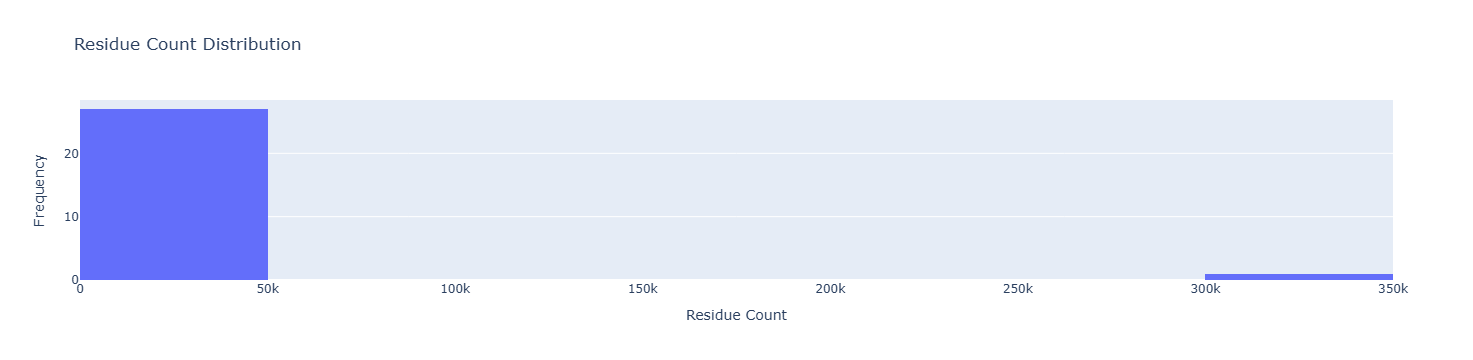

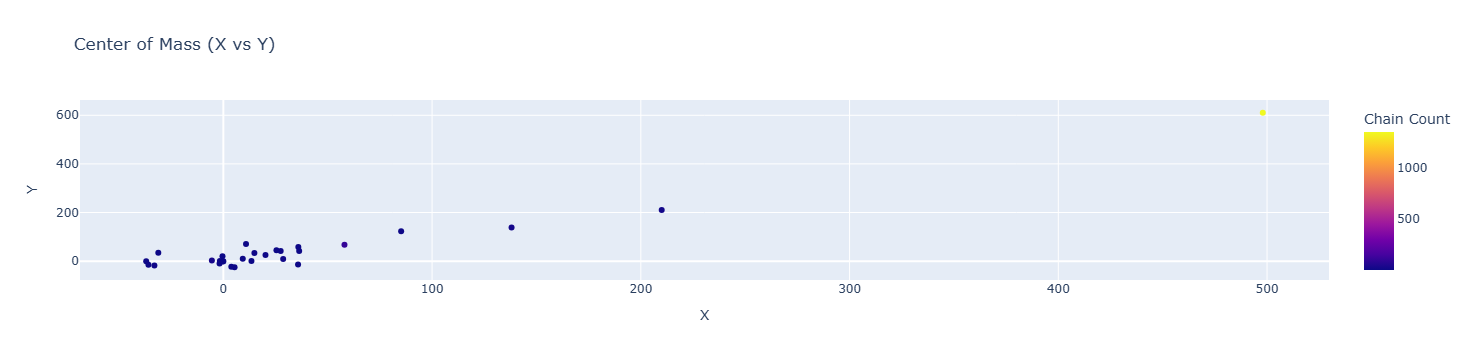

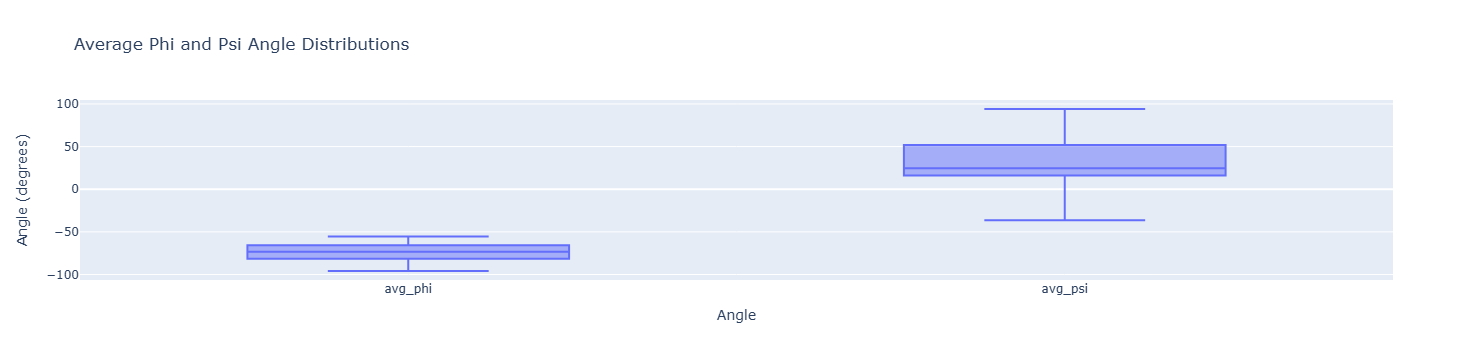

In [7]:
fig1 = px.histogram(df, x='residue_count', title='Residue Count Distribution')
fig1.update_xaxes(title='Residue Count')
fig1.update_yaxes(title='Frequency')
fig1.show()

fig2 = px.scatter(df, x='center_x', y='center_y', color='chain_count',
                 title='Center of Mass (X vs Y)', labels={'center_x':'X', 'center_y':'Y', 'chain_count':'Chain Count'})
fig2.show()

fig3 = px.box(df, y=['avg_phi', 'avg_psi'], title='Average Phi and Psi Angle Distributions',
             labels={'value':'Angle (degrees)', 'variable':'Angle'})
fig3.show()

### Exporting Metrics to CSV

Finally, we save the compiled metrics into `results/dataset_metrics.csv`, which can be used for further downstream analysis or shared with collaborators.  


In [8]:
os.makedirs('results', exist_ok=True)
df.to_csv('results/dataset_metrics.csv', index=False)